# 대형 운송수단 연료유량 에측모델 개발
다양한 센서 정보를 활용한 대형 운송수단의 연료 유량 예측 모델 개발

마지막 target은 연료 유량을 나타낸다

결측치는 없음

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
import seaborn as sns
import scipy as sp
import scipy.stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from keras.callbacks import ModelCheckpoint, EarlyStopping


import tensorflow as tf

pd.set_option('display.max_row', 100000)
pd.set_option('display.max_columns', 100000)

## 데이터 확인해보기

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
output_sample = pd.read_csv('/content/output_sample.csv')

In [ ]:
print(train.info())
print(train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6851 entries, 0 to 6850
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_0   6851 non-null   float64
 1   feature_1   6851 non-null   float64
 2   feature_2   6851 non-null   float64
 3   feature_3   6851 non-null   float64
 4   feature_4   6851 non-null   float64
 5   feature_5   6851 non-null   float64
 6   feature_6   6851 non-null   float64
 7   feature_7   6851 non-null   float64
 8   feature_8   6851 non-null   float64
 9   feature_9   6851 non-null   float64
 10  feature_10  6851 non-null   float64
 11  feature_11  6851 non-null   float64
 12  feature_12  6851 non-null   float64
 13  feature_13  6851 non-null   float64
 14  feature_14  6851 non-null   float64
 15  target      6851 non-null   float64
dtypes: float64(16)
memory usage: 856.5 KB
None
         feature_0    feature_1     feature_2    feature_3    feature_4  \
count  6851.000000  6851.000000 

In [ ]:
#sns.pairplot(train[['feature_0', 'feature_1','feature_2','feature_3','feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_9', 'feature_10', 'feature_12', 'feature_13', 'feature_14']], diag_kind="kde")

In [ ]:
train_stats = train.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
feature_0,6851.0,6.469988,1.834862e+00,1.138,5.1400,6.175,8.2060,9.300
feature_1,6851.0,18.858707,5.387539e+00,3.000,15.0000,18.000,24.0000,27.000
feature_2,6851.0,36142.251710,1.909584e+04,5777.169,21627.5415,29793.138,50993.2365,72783.338
feature_3,6851.0,2446.206168,6.805625e+02,1320.913,1924.3180,2307.368,3087.4580,3560.740
feature_4,6851.0,8795.224271,6.820504e+02,6646.546,8472.9125,8828.360,9302.9105,9797.103
feature_5,6851.0,306.315294,1.750697e+02,6.026,175.2470,246.261,437.9885,645.249
feature_6,6851.0,306.315294,1.750697e+02,6.026,175.2470,246.261,437.9885,645.249
feature_7,6851.0,809.617253,1.413620e+02,617.242,700.3845,781.756,915.1240,1115.797
feature_8,6851.0,288.000000,0.000000e+00,288.000,288.0000,288.000,288.0000,288.000
feature_9,6851.0,679.001242,5.749051e+01,569.403,634.7325,670.669,728.5830,789.094


In [ ]:
train_x = train[['feature_0', 'feature_1','feature_2','feature_3','feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_9', 'feature_10', 'feature_12', 'feature_13', 'feature_14']]
real_test_x = test[['feature_0', 'feature_1','feature_2','feature_3','feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_9', 'feature_10', 'feature_12', 'feature_13', 'feature_14']]
train_y = train[['target']]

In [ ]:
print(train_x.head(20))
print(train_y.max())
print(train_y.min())

    feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0       4.161       12.0  14724.519   1547.472   7811.678    113.798   
1       6.175       18.0  29761.446   2306.845   8793.238    245.992   
2       7.148       21.0  38989.395   2678.078   9129.161    332.198   
3       6.175       18.0  29795.455   2307.276   8835.771    246.284   
4       5.140       15.0  21624.321   1924.328   8464.731    175.214   
5       9.300       27.0  72765.740   3560.396   9768.369    644.976   
6       5.140       15.0  21633.627   1924.341   8494.497    175.272   
7       9.300       27.0  72765.734   3560.407   9771.878    644.880   
8       5.140       15.0  21626.917   1924.319   8469.517    175.252   
9       6.175       18.0  29791.952   2307.395   8822.979    246.273   
10      9.300       27.0  72777.351   3560.424   9778.601    645.164   
11      4.161       12.0  14717.137   1547.445   7704.397    113.730   
12      6.175       18.0  29790.695   2307.464   8820.299    246

In [ ]:
#모델 생성 및 적용
pca = PCA()
pca.fit(train_x)

#PC score 구하기
pcscore = pca.transform(train_x)

In [ ]:
print(train_x.head(20))

    feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0       4.161       12.0  14724.519   1547.472   7811.678    113.798   
1       6.175       18.0  29761.446   2306.845   8793.238    245.992   
2       7.148       21.0  38989.395   2678.078   9129.161    332.198   
3       6.175       18.0  29795.455   2307.276   8835.771    246.284   
4       5.140       15.0  21624.321   1924.328   8464.731    175.214   
5       9.300       27.0  72765.740   3560.396   9768.369    644.976   
6       5.140       15.0  21633.627   1924.341   8494.497    175.272   
7       9.300       27.0  72765.734   3560.407   9771.878    644.880   
8       5.140       15.0  21626.917   1924.319   8469.517    175.252   
9       6.175       18.0  29791.952   2307.395   8822.979    246.273   
10      9.300       27.0  72777.351   3560.424   9778.601    645.164   
11      4.161       12.0  14717.137   1547.445   7704.397    113.730   
12      6.175       18.0  29790.695   2307.464   8820.299    246

# 슬라이싱해서 학습데이터와 테스트데이터를 나눔
MinMax Normalization 사용

In [ ]:
scaler_x=MinMaxScaler()
scaler_x.fit(train_x)
Normalization_data_x=scaler_x.transform(train_x)

train_xMM = pd.DataFrame(data=Normalization_data_x)

scaler_y=MinMaxScaler()
scaler_y.fit(train_y)
train_Normalization_data_y=scaler_y.transform(train_y)

train_yMM = pd.DataFrame(data=train_Normalization_data_y)

In [ ]:
test_Normalization_data=scaler_x.transform(real_test_x)

real_test_xMM = pd.DataFrame(data=test_Normalization_data)

In [ ]:
train_xMM.head(5)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.370375,0.375,0.133530,0.101150,0.369818,0.168598,0.168598,0.042298,0.176862,0.114869,0.117306,0.090909,0.177371
1,0.617128,0.625,0.357941,0.440182,0.681369,0.375403,0.375403,0.320394,0.442913,0.376295,0.397126,0.333333,0.367868
2,0.736339,0.750,0.495659,0.605924,0.787992,0.510263,0.510263,0.412085,0.548857,0.515235,0.527692,0.515152,0.468454
3,0.617128,0.625,0.358449,0.440375,0.694869,0.375859,0.375859,0.304079,0.449208,0.372029,0.379734,0.333333,0.360134
4,0.490321,0.500,0.236503,0.269403,0.577100,0.264678,0.264678,0.146016,0.279543,0.247105,0.255952,0.242424,0.256323


In [ ]:
print(train_Normalization_data_y.shape)
print(train_y.shape)

train_x, test_x, train_y, test_y = train_test_split(train_xMM, train_yMM, test_size = 0.2, random_state=0, shuffle = True)


(6851, 1)
(6851, 1)


In [ ]:
# PC_ratio = pca.explained_variance_ratio_
# PC_ratio_df = pd.DataFrame(PC_ratio)
# PC_ratio_df.plot(kind='bar', logy= True)

In [ ]:
print(train_x.shape)
print(train_y.shape)

print(test_x.shape)
print(test_y.shape)

(5480, 13)
(5480, 1)
(1371, 13)
(1371, 1)


# 오차값(RMSE)

In [ ]:
def RMSE(test_y, pred_y):
    mse = mean_squared_error(test_y, pred_y)
    mse = np.sqrt(mse)
    return mse

# 다중 선형회귀 
다른 모델 적용

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'tanh', input_shape = (train_x.shape)),
    tf.keras.layers.Dense(64, activation = "tanh"),
    tf.keras.layers.Dense(32, activation = "tanh"),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer = optimizer, loss = 'mse', metrics = [tf.keras.metrics.RootMeanSquaredError()])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5480, 128)         1792      
_________________________________________________________________
dense_1 (Dense)              (None, 5480, 64)          8256      
_________________________________________________________________
dense_2 (Dense)              (None, 5480, 32)          2080      
_________________________________________________________________
dense_3 (Dense)              (None, 5480, 1)           33        
Total params: 12,161
Trainable params: 12,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor = 'val_root_mean_squared_error', min_delta = 0.00001, patience = 50, verbose =1, mode = 'auto', baseline = None, restore_best_weights = True)
history = model.fit(train_x, train_y, epochs = 10000, validation_split = 0.25, batch_size = 8192 ,callbacks=(early_stopping))
#pred_y = model.predict(test_x)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 3842/10000
1/1 [==============================] - 0s 57ms/step - loss: 6.0438e-06 - root_mean_squared_error: 0.0025 - val_loss: 6.4978e-06 - val_root_mean_squared_error: 0.0025
Epoch 3843/10000
1/1 [==============================] - 0s 52ms/step - loss: 6.0405e-06 - root_mean_squared_error: 0.0025 - val_loss: 6.4944e-06 - val_root_mean_squared_error: 0.0025
Epoch 3844/10000
1/1 [==============================] - 0s 52ms/step - loss: 6.0372e-06 - root_mean_squared_error: 0.0025 - val_loss: 6.4911e-06 - val_root_mean_squared_error: 0.0025
Epoch 3845/10000
1/1 [==============================] - 0s 55ms/step - loss: 6.0340e-06 - root_mean_squared_error: 0.0025 - val_loss: 6.4877e-06 - val_root_mean_squared_error: 0.0025
Epoch 3846/10000
1/1 [==============================] - 0s 45ms/step - loss: 6.0307e-06 - root_mean_squared_error: 0.0025 - val_loss: 6.4843e-06 - val_root_mean_squared_error: 0.0025
Epoch 3847/10000
1/1 [===========================

# Epoch 791/1000
129/129 [==============================] - 0s 2ms/step - loss: 2.8020e-05 - root_mean_squared_error: 0.0053 - val_loss: 2.9250e-05 - val_root_mean_squared_error: 0.0054

#Epoch 100/1000
129/129 [==============================] - 0s 2ms/step - loss: 8.4812e-05 - root_mean_squared_error: 0.0092 - val_loss: 4.6219e-07 - val_root_mean_squared_error: 6.7984e-04

#Epoch 6340/10000
1/1 [==============================] - 0s 45ms/step - loss: 1.1910e-06 - root_mean_squared_error: 0.0011 - val_loss: 1.5807e-06 - val_root_mean_squared_error: 0.0013

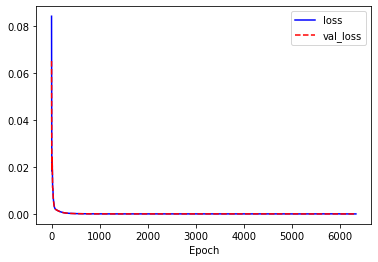

In [ ]:
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
test = model.predict(real_test_xMM)

predict_data = scaler_y.inverse_transform(test)
print(predict_data)

outputdf = pd.DataFrame(predict_data, columns=['target'])
print(outputdf)
outputdf.to_csv('/content/output_sample.csv', index=False)
print(1)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
84    0.255783
85    0.116892
86    0.134445
87    0.219212
88    0.224550
89    0.097897
90    0.228632
91    0.130155
92    0.254957
93    1.768433
94    0.169234
95    0.118341
96    0.226268
97    0.124251
98    0.092273
99    0.256350
100   0.196687
101   0.217553
102   0.236281
103   0.235305
104   0.105117
105   0.234353
106   0.106441
107   0.216218
108   0.268490
109   0.662423
110   0.207321
111   0.231485
112   0.137653
113   0.109654
114   0.155542
115   1.818377
116   0.882876
117   0.670750
118   0.143470
119   0.258032
120   1.233625
121   0.175895
122   0.225972
123   0.230982
124   0.224703
125   0.227797
126   0.142285
127   0.234416
128   0.195652
129   0.880225
130   0.226426
131   0.209100
132   0.212531
133   0.184815
134   0.880334
135   0.101540
136   0.119115
137   1.224865
138   0.164288
139   0.117053
140   0.251140
141   0.222525
142   0.164411
143   0.240579
144   0.126741
145   0.184556
146   0.141965
147   0.235330
148 